<a href="https://colab.research.google.com/github/allokeen/ML_Colorizing/blob/main/Convolutional_Colorizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import google.colab
google.colab.drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os

In [2]:
img1 = load_img('/content/drive/MyDrive/Colab Notebooks/Faces/Aaron_Sorkin_0001.jpg')
img1 = img_to_array(img1).astype(np.uint8)
img1 = cv2.resize(img1, (256, 256))
img1.shape



(256, 256, 3)

In [3]:
def load_image_for_model(file_path):
    img = load_img(file_path)
    img = img_to_array(img).astype(np.uint8)
    img = cv2.resize(img, (256, 256))
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    return img_lab

def to_LAB_arrays(path_to_imgs):
    L_channel = []
    AB_channels = []
    for path in path_to_imgs:
        img_lab = load_image_for_model(path)
        L_channel.append(img_lab[:, :, 0]/255)
        AB_channels.append(img_lab[:, :, 1:]/255)
    L_channel = np.array(L_channel).reshape(-1, 256, 256, 1)
    AB_channels = np.array(AB_channels).reshape(-1, 256, 256, 2)
    return L_channel, AB_channels


In [16]:
def build_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(256, 256, 1)))  # Dostosowane do rozmiaru obrazków 256x256

    # Warstwy konwolucyjne
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))  # 128x128


    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))  # 64x64


    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))  # 32x32


    # Warstwy dekodujące
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2DTranspose(256, (3, 3), activation='relu', padding='same', strides=2))  # 64x64

    model.add(Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=2))  # 128x128

    model.add(Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2))  # 256x256

    model.add(Conv2D(2, (3, 3), activation='sigmoid', padding='same'))  # Zmieniamy wyjście na 2 kanały

    model.compile(optimizer='adam', loss='mse')
    return model

# Learning phase

In [5]:
# Preprocessing
img_paths = [os.path.join('/content/drive/MyDrive/Colab Notebooks/Faces/', fname) for fname in os.listdir('/content/drive/MyDrive/Colab Notebooks/Faces')]
L_arr, AB_arr = to_LAB_arrays(img_paths)


In [17]:
# Building and training
model = build_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint_path = "model_checkpointsNext/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Creating callbacks to save model
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
    period=1  # saving every epoch
)

model.fit(L_arr, AB_arr, epochs=50, batch_size=16, validation_split=0.1, callbacks=[cp_callback, early_stopping])
model.save('saved_model/my_model_next')

Epoch 1/50
620/620 [==============================] - ETA: 0s - loss: 0.0025
Epoch 1: val_loss improved from inf to 0.00226, saving model to model_checkpointsA100noDrop/cp-0001.ckpt
620/620 [==============================] - 35s 47ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 2/50
620/620 [==============================] - ETA: 0s - loss: 0.0023
Epoch 2: val_loss improved from 0.00226 to 0.00219, saving model to model_checkpointsA100noDrop/cp-0002.ckpt
620/620 [==============================] - 27s 43ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 3/50
620/620 [==============================] - ETA: 0s - loss: 0.0022
Epoch 3: val_loss did not improve from 0.00219
620/620 [==============================] - 27s 43ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 4/50
619/620 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 4: val_loss improved from 0.00219 to 0.00210, saving model to model_checkpointsA100noDrop/cp-0004.ckpt
620/620 [==============================] - 27s 43

# Tesing

1/1 [==============================] - 0s 26ms/step


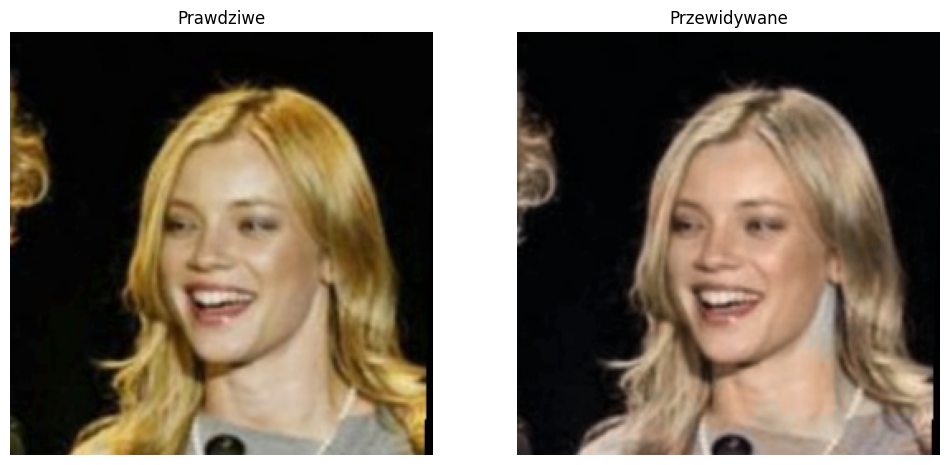

1/1 [==============================] - 0s 21ms/step


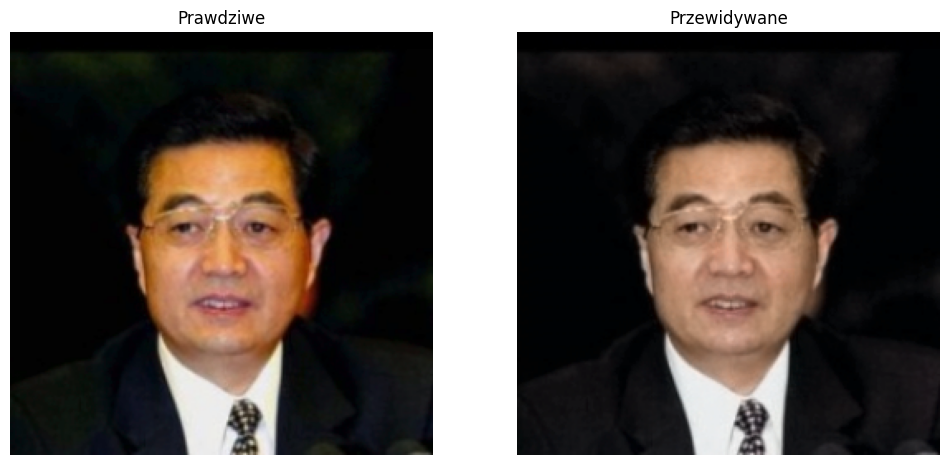

In [19]:

#test_img_paths = [os.path.join('/content/drive/My Drive/Colab Notebooks/ml-dataset-256x256/', fname) for fname in os.listdir('/content/drive/My Drive/Colab Notebooks/ml-dataset-256x256')]
test_img_paths = ['/content/drive/MyDrive/Colab Notebooks/Faces/Amy_Smart_0001.jpg']
#test_img_paths = ['/content/drive/My Drive/Colab Notebooks/test/test2.png']
L_test, AB_test_true = to_LAB_arrays(test_img_paths)
AB_test_pred = model.predict(L_test)
#print(AB_test_true[:,:,0])
#print(AB_test_true[:,:,1])
#print(AB_test_pred[:,:,1])

import matplotlib.pyplot as plt

def plot_results(L, AB_true, AB_pred, index=0):
    """
    Funkcja do wyświetlenia wyników predykcji.
    """
    # Skala wartości LAB z powrotem do zakresu [0, 255]
    L = (L[index] * 255).astype(np.uint8)
    AB_true = (AB_true[index] * 255).astype(np.uint8)  # Skala AB z powrotem do zakresu [-128, 128]
    AB_pred = (AB_pred[index] * 255).astype(np.uint8)

    # Połączenie LAB i konwersja do RGB
    img_true = cv2.merge((L, AB_true[:, :, 0], AB_true[:, :, 1]))
    img_true = cv2.cvtColor(img_true, cv2.COLOR_LAB2RGB)

    img_pred = cv2.merge((L, AB_pred[:, :, 0], AB_pred[:, :, 1]))
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_LAB2RGB)

    # Wyświetlenie obrazów i modlitwa o dobry wynik
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(img_true)
    axs[0].set_title('Prawdziwe')
    axs[0].axis('off')

    axs[1].imshow(img_pred)
    axs[1].set_title('Przewidywane')
    axs[1].axis('off')

    plt.show()

# Wyświetl obraz
plot_results(L_test, AB_test_true, AB_test_pred, index=0)

test_img_paths = ['/content/drive/MyDrive/Colab Notebooks/test/Hu_Jintao_0006.jpg']
L_test, AB_test_true = to_LAB_arrays(test_img_paths)
AB_test_pred = model.predict(L_test)

plot_results(L_test, AB_test_true, AB_test_pred, index=0)